In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
from tensorflow.keras.layers import Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=np.load("./drive/My Drive/audio_train.npy")
test=np.load("./drive/My Drive/audio_test.npy")

In [4]:
train_labels=pd.read_csv("./drive/My Drive/labels_train.csv")
sample_submission=pd.read_csv("./drive/My Drive/sample_submission.csv")

In [ ]:
train_labels

,id,label
0,0,5
1,1,1
2,2,1
3,3,0
4,4,9
...,...,...
937,937,9
938,938,1
939,939,1
940,940,5


In [5]:
label = list(train_labels['label'])

y_train = np.empty([len(train),1])
for i in range(len(label)):
  y_train[i] = label[i]
y_train = np.array(y_train, dtype='uint8')

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

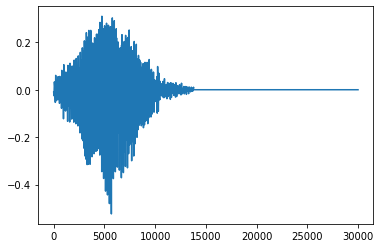

In [ ]:
plt.plot(train[2])

In [ ]:
print(train_labels.label.unique())

[5 1 0 9 4 6 7 3 8]


In [ ]:
print(sample_submission.label.unique())

[ 1  6  3  7  4  8  9  5  2  0 10]


In [ ]:
print(np.shape(test)[1])

30000


In [6]:
verbose, epochs, batch_size = 0, 10, 32

In [7]:
n_timesteps, n_features, n_outputs = train.shape[0], train.shape[1], train_labels.shape[0]

In [8]:
n_timesteps

942

In [9]:
train.shape[0],train.shape[1]

(942, 30000)

In [10]:
train1=np.reshape(train,(train.shape[0],500,60,1))
train1.shape

(942, 500, 60, 1)

In [11]:
test1=np.reshape(test,(test.shape[0],500,60,1))
test1.shape

(558, 500, 60, 1)

In [12]:
train_labels.shape

(942, 2)

In [13]:
train.shape[1]

30000

In [14]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional, ELU
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import LSTM

In [15]:
# Build CVAE model
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, n_rows, n_cols, n_channels, n_latent_dim):
        super(CVAE, self).__init__()
        self.rows = n_rows
        self.cols = n_cols
        self.channels = n_channels
        self.latent_dim = n_latent_dim

        self.encoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(500, 60, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dim + self.latent_dim),]) # No activation

        self.decoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
            tf.keras.layers.Dense(units=(125)*(15)*32, activation=tf.nn.relu), 
            tf.keras.layers.Reshape(target_shape=(125, 15, 32)), # 16x16x32
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),]) # No activation

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [17]:
# Training
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, 
    and uses the latter to update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def train(X_train, N_EPOCHS, model, optimizer):
    for epoch in range(1, N_EPOCHS+1):
        start_time = time.time()
        #loss = tf.keras.metrics.Mean()
        for x in X_train:
            train_step(model, x, optimizer)
            #loss(compute_loss(model, x))
        #elbo = -loss.result()
        end_time = time.time()
        #print('Epoch {0}: ELBO is {1} and Time elapse is {2}.'
            #.format(epoch, elbo, end_time - start_time))
        print('In Epoch {0}, Time elapse: {1}.'
            .format(epoch, end_time - start_time))

In [18]:
# Plotting
def gen_latent_data(model, data):
    # Generate latent data (np.array) from given dataset
    mean, logvar = model.encode(data)
    z = model.reparameterize(mean, logvar)
    return z.numpy()

def plot_latent_data(model, data, label):
    # Plot the latent data on 2D plane.
    color_list = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    z = gen_latent_data(model, data) # convert to np.array before plotting
    for i in range(len(label)):
        plt.plot(z[i,0], z[i,1], color_list[label[i]], markersize = 5)
    #plt.axis('off')
    plt.savefig('CVAE_scatter.png')
    plt.show()

In [20]:
if __name__ == '__main__':
    # Initialize the arguments
    
    try:
        N_EPOCHS = int(sys.argv[1])
        LATENT_DIM = int(sys.argv[2])
        WHICH_PART = int(sys.argv[3])
    except:
        N_EPOCHS = 100
        LATENT_DIM = 50 # set dim=2 to a plane for visualization  
        WHICH_PART = 2 # select the part of question
        
    ROWS = 500
    COLS = 60
    CHANNELS = 1
    sample_rate = 22050 # default
    
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    # Import audio dataset
    X_train = np.load("./drive/My Drive/audio_train.npy")
    X_test = np.load("./drive/My Drive/audio_test.npy")


    data = np.vstack((X_train, X_test)) # merge for clustering
    Y_train = pd.read_csv("./drive/My Drive/labels_train.csv")
    Y_train = np.array(Y_train)[:, -1] # set(Y_train) = {0, 1, 3, 4, 5, 6, 7, 8, 9}
    Y_test_fake = np.array([2 for i in range(len(X_test))])
    label = np.hstack((Y_train, Y_test_fake))
    print("X_train/X_test/data's shape: ", X_train.shape, X_test.shape, data.shape)
    if WHICH_PART == 3:
        data = X_train
    # Preprocessing
    data_sp = get_spectrogram_data(data, sample_rate, n_mels=59)
    data_scaled = MinMaxScaler(data_sp, -1, 1)
    TRAIN_SIZE = len(data_scaled)
    data_train = (tf.data.Dataset.from_tensor_slices(data_scaled)
                .shuffle(TRAIN_SIZE).batch(BATCH_SIZE)) # Shuffle the dataset
    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    # Instantiate the model
    model = CVAE(ROWS, COLS, CHANNELS, LATENT_DIM)
    # Train the model
    train(data_train, N_EPOCHS, model, optimizer)
    # Part 1: Plotting the latent data on 2-D plane. (LATENT_DIM = 2)
    if WHICH_PART == 1:
        #z = gen_latent_data(model, data_scaled)
        #np.save("latent.npy", z)
        plot_latent_data(model, data_scaled, label)
        print("Plotting completed!")
    # Part 2: Generate synthetic audio by VAE
    if WHICH_PART == 2:
        X_pred = gen_synthetic_data(model, BATCH_SIZE, LATENT_DIM)
        np.save("synData.npy", X_pred)
        print("synData.npy generated!")
    # Part 3: Implement Random Forest Classifier as baseline
    if WHICH_PART == 3:
        from sklearn.ensemble import RandomForestClassifier
        data_encoded = gen_latent_data(model, data_scaled)
        rfc = RandomForestClassifier(oob_score=True, random_state=10)
        rfc.fit(data_encoded, Y_train)
        # Evaluation
        print("out-of-bag (OOB) score: ", rfc.oob_score_)

X_train/X_test/data's shape:  (942, 30000) (558, 30000) (1500, 30000)


NameError: ignored

In [ ]:
pred = model.predict(test1)

In [ ]:
np.argmax(pred[1])

9

In [ ]:
predLabel = np.empty([len(test),2],dtype=int)
for i in range(len(pred)):
  predLabel[i][0] = np.int(i)
  predLabel[i][1] = np.int(np.argmax(pred[i]))


In [ ]:
df = pd.DataFrame(predLabel, columns= ['id', 'label'])

df.to_csv (r'haiqzhu5.csv', index = False, header=True)

In [ ]:
sample_submission

,id,label
0,0,1
1,1,6
2,2,3
3,3,7
4,4,4
...,...,...
553,553,6
554,554,0
555,555,2
556,556,9


In [ ]:
df

,id,label
0,0,5
1,1,9
2,2,4
3,3,1
4,4,4
...,...,...
553,553,1
554,554,5
555,555,5
556,556,7
